# Generate illustrations of tessellation

In [167]:
import geopandas as gpd
import momepy as mm
import pygeos
import numpy as np
from scipy.spatial import Voronoi
import pandas as pd
from mapclassify import greedy

In [2]:
gdf = gpd.read_file(mm.datasets.get_path('bubenec'), layer='buildings')

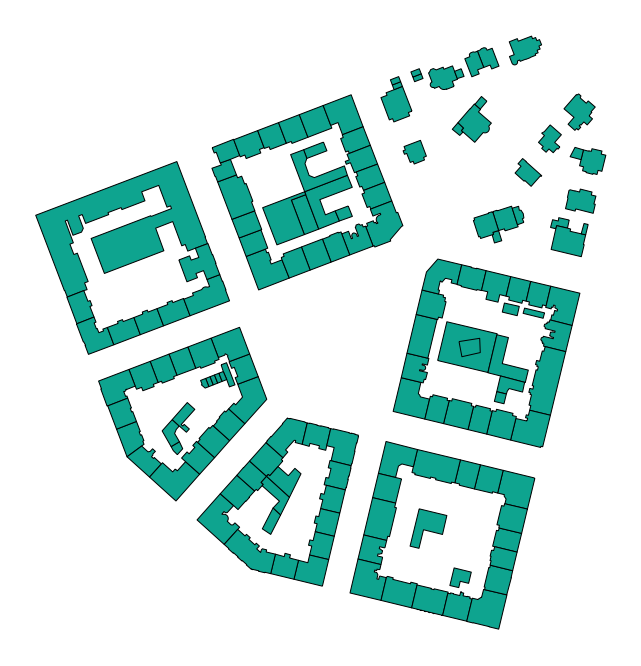

In [190]:
gdf.plot(figsize=(12, 12), color='#0ea48f', edgecolor='k').set_axis_off()

In [4]:
limit = mm.buffered_limit(gdf, 50)

## Step 1: Shrink

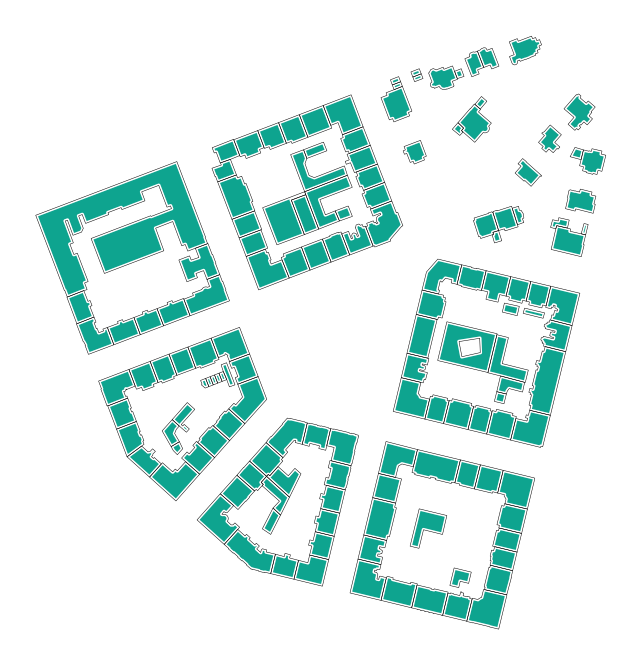

In [178]:
shrinked = gdf.buffer(-2)
ax = gdf.plot(figsize=(12, 12), facecolor='none', linewidth=.5, edgecolor='k')
shrinked.plot(ax=ax, color='#0ea48f')
ax.set_axis_off()

## Step 2: Point array

In [181]:
distance = 4

points = np.empty((0, 2))
ids = []
lines = shrinked.exterior.values.data
lines[26] = pygeos.from_shapely(shrinked.geometry.values[26].boundary)  # pygeos bugfix
lengths = shrinked.length
for ix, line, length in zip(shrinked.index, lines, lengths):
    pts = pygeos.line_interpolate_point(
        line,
        np.linspace(0.1, length - 0.1, num=int((length - 0.1) // distance)),
    )  # .1 offset to keep a gap between two segments
    if len(pts) > 0:
        points = np.append(points, pygeos.get_coordinates(pts), axis=0)
        ids += [ix] * len(pts)

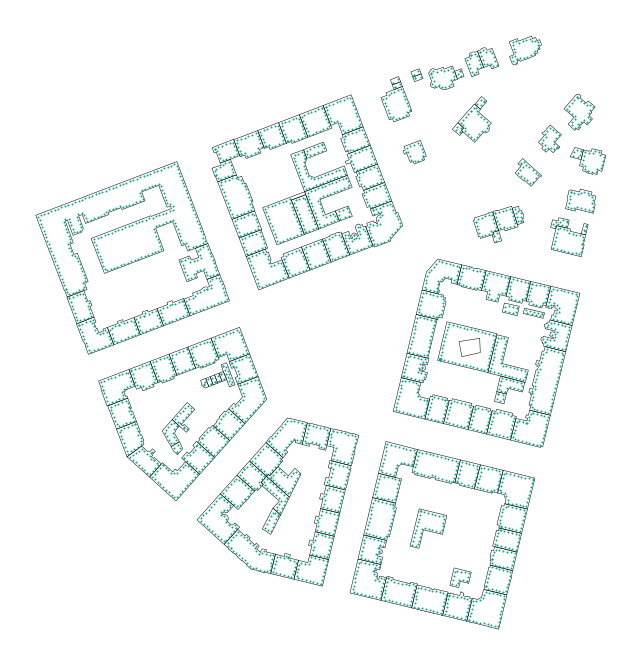

In [182]:
ax = gdf.plot(figsize=(12, 12), facecolor='none', linewidth=.5, edgecolor='k')
gpd.GeoSeries(pygeos.points(points)).plot(ax=ax, markersize=1, color='#0ea48f')
ax.set_axis_off()

In [183]:
# add hull to resolve issues with infinity
# this is just a correction step ensuring the algorithm will work correctly
series = gpd.GeoSeries(limit)
bounds = series.total_bounds
width = bounds[2] - bounds[0]
leng = bounds[3] - bounds[1]
hull = series.geometry[[0]].buffer(2 * width if width > leng else 2 * leng)
line = hull.boundary.values.data[0]
length = hull.length[0]

In [184]:
pts = pygeos.line_interpolate_point(
    line,
    np.linspace(0.1, length - 0.1, num=int((length - 0.1) // distance)),
)  # .1 offset to keep a gap between two segments
points = np.append(points, pygeos.get_coordinates(pts), axis=0)
ids += [-1] * len(pts)

## Step 3: Voronoi

In [185]:
voronoi_diagram = Voronoi(np.array(points))

vertices = pd.Series(voronoi_diagram.regions).take(voronoi_diagram.point_region)
polygons = []
for region in vertices:
    if -1 not in region:
        polygons.append(pygeos.polygons(voronoi_diagram.vertices[region]))
    else:
        polygons.append(None)

regions_gdf = gpd.GeoDataFrame(
    {'unique_id': ids}, geometry=polygons
).dropna()
regions_gdf = regions_gdf.loc[
    regions_gdf['unique_id'] != -1
]  # delete hull-based cells

In [186]:
voronoi_tessellation = gpd.clip(regions_gdf, series)

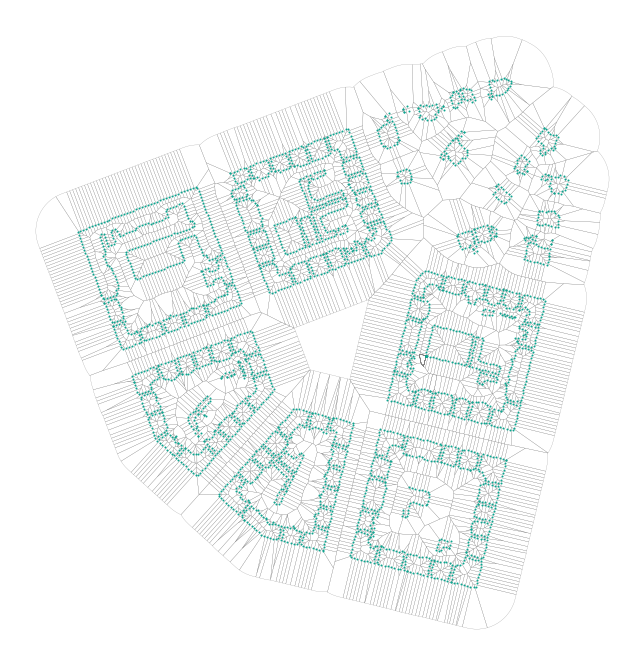

In [187]:
# ax = gdf.plot(figsize=(12, 12), facecolor='none', linewidth=.5, edgecolor='k', zorder=2)
ax = gpd.GeoSeries(pygeos.points(points[:3333])).plot(figsize=(12, 12), markersize=1, zorder=3, color='#0ea48f')
voronoi_tessellation.plot(ax=ax, facecolor='none', linewidth=.2, edgecolor='gray')
ax.set_axis_off()

## Step 4: Dissolve

In [188]:
tessellation = voronoi_tessellation.dissolve('unique_id')

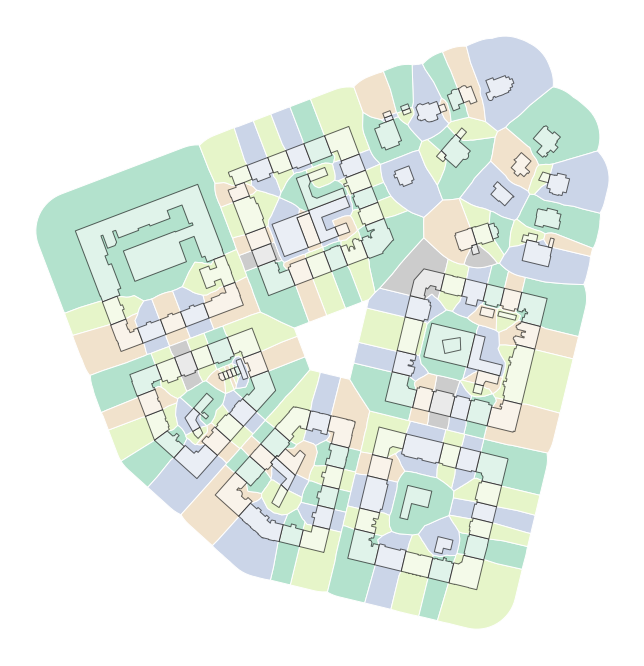

In [189]:
ax = gdf.plot(figsize=(12, 12), facecolor='white', zorder=2, alpha=.6, edgecolor='k')
tessellation.plot(greedy(tessellation, strategy='largest_first'), ax=ax, categorical=True, cmap='Pastel2', edgecolor='w')
ax.set_axis_off()

## OSM data

In [192]:
import osmnx as ox

gdf = ox.footprints.footprints_from_place(place='Milevsko, Czechia')
gdf_projected = ox.projection.project_gdf(gdf)

<AxesSubplot:>

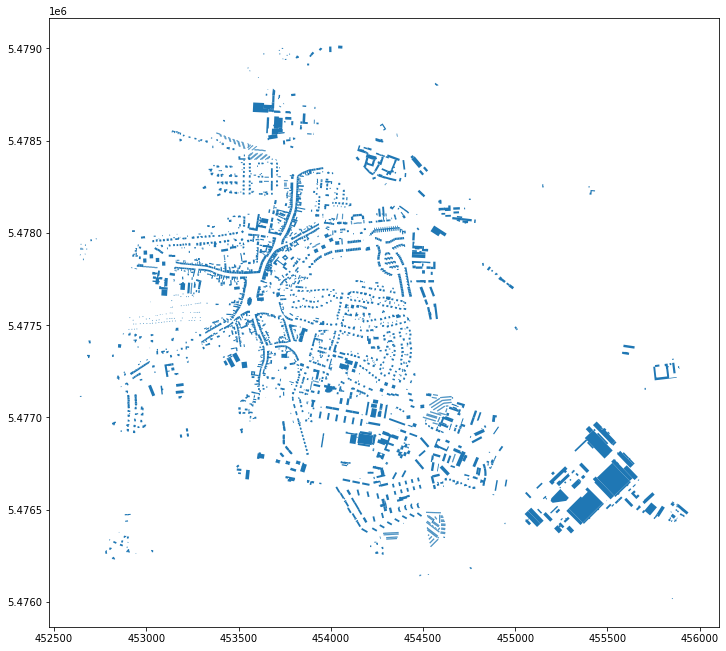

In [196]:
gdf = gdf_projected.cx[452500:456500, 5476000:5479000].reset_index(drop=True)
gdf.plot(figsize=(12, 12))

## Animation

Sequence:
1. wide sat image
2. zoom to small extent
3. tessellation steps
4. zoom back to large extent